In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
import datetime as dt
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(latest_date)

('2017-08-23',)


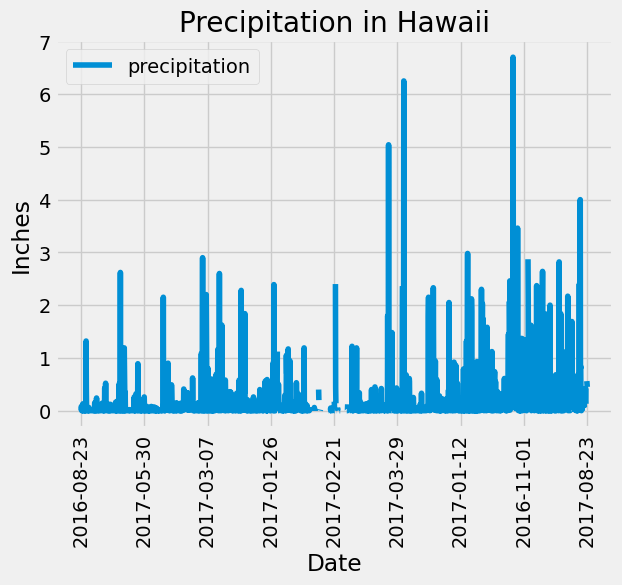

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
date_chop= latest_date[0].split("-")
start_year= int(date_chop[0])-1
start_date= str(start_year)+"-"+date_chop[1]+"-"+date_chop[2]

# Perform a query to retrieve the data and precipitation scores
prcp_data = [Measurement.date, 
       Measurement.prcp]

prcp_query = session.query(*prcp_data).\
        filter(func.strftime(Measurement.date) >= start_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_query, columns=['measurement_date', 'precipitation'])

# Sort the dataframe by date
prcp_df.sort_values(by='measurement_date')
prcp_df.set_index('measurement_date', inplace=True)
prcp_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
data_plot = prcp_df.plot(rot=90, title = "Precipitation in Hawaii", xlabel='Date', ylabel = "Inches")

x_ticks = np.linspace(start=0, stop=len(prcp_df.index)-1, num=9, dtype=int)
data_plot.set_xticks(x_ticks)
data_plot.set_xticklabels([prcp_df.index[i] for i in x_ticks], rotation=90)


#plt.tight_layout()
plt.show()

In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [23]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
traffic = [Measurement.station, 
       func.count(Measurement.station)]
active_stations = session.query(*traffic).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
m_stat = active_stations[0][0]

sl = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
station_temp_summary = session.query(*sl).\
        filter(Measurement.station == m_stat).\
        group_by(Measurement.station)
for station in station_temp_summary:
    print(station)

(54.0, 85.0, 71.66378066378067)


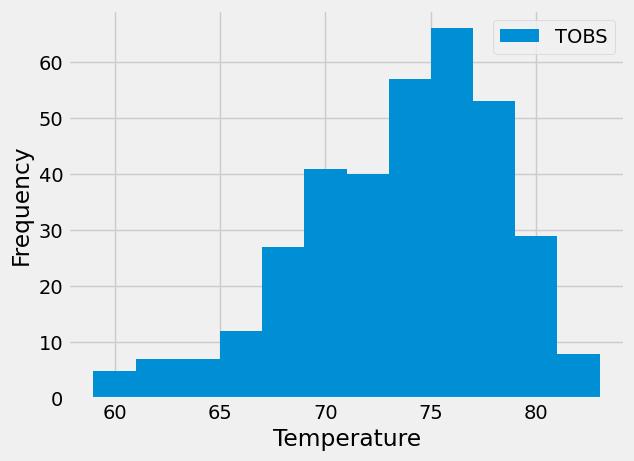

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sl = [Measurement.date, 
       Measurement.tobs]
station_temps = session.query(*sl).\
        filter(func.strftime(Measurement.date) >= start_date, Measurement.station == m_stat).\
        group_by(Measurement.date).\
        order_by(Measurement.date).all()

station_temps_df = pd.DataFrame(station_temps, columns=['Measurement Date', 'Temperature'])

plt.hist(station_temps_df['Temperature'],bins=12, density=False, label="TOBS")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Close Session

In [27]:
# Close Session
session.close()